# Case study for Hambach Surface Mine - DEM analysis
This notebook is part of a series of notebooks for a case study of the Hambach Surface Mine, one of the largest open mines in Germany. In this notebook, we look at the various Digital Elevation Models (DEMs) available from the SENTINEL2_L1C data collection. 

## Configuration and imports

In [1]:
from sentinelhub import SHConfig

config = SHConfig("sentinel-hub-dida-testing")

if not config.sh_client_id or not config.sh_client_secret:
    print("Warning! To use Process API, please provide the credentials (OAuth client ID and client secret).")

In [2]:
import datetime
import os

import yaml
import matplotlib.pyplot as plt
import numpy as np

from sentinelhub import (
    CRS,
    BBox,
    DataCollection,
    DownloadRequest,
    MimeType,
    MosaickingOrder,
    SentinelHubDownloadClient,
    SentinelHubRequest,
    bbox_to_dimensions,
)

from amoki.config import DATA_DIR, REFERENCES_DIR
from amoki.utilities.sentinelhub_utils import plot_image, get_volume_from_dem_array

## Setting area of interest
The bounding box for the Hambach surface mine (one of the biggest open mines in Germany) in `WGS84` coordinate system is approximately `[6.399536,50.838034,6.645355,50.962319]` (longitude and latitude coordinates of lower left and upper right corners). You can get the bbox for a different area at the [bboxfinder](http://bboxfinder.com/) website.

In [3]:
hambach_coords_wgs84 = (6.399536,50.838034,6.645355,50.962319)

When the bounding box bounds have been defined, you can initialize the `BBox` of the area of interest. Using the `bbox_to_dimensions` utility function, you can provide the desired resolution parameter of the image in meters and obtain the output image shape.

In [4]:
resolution = 10
hambach_bbox = BBox(bbox=hambach_coords_wgs84, crs=CRS.WGS84)
hambach_size = bbox_to_dimensions(hambach_bbox, resolution=resolution)

print(f"Image shape at {resolution} m resolution: {hambach_size} pixels")

Image shape at 10 m resolution: (1775, 1324) pixels


# DEM analysis
There are multiple DEM data collections available through Sentinel

In [5]:
print("Supported DataCollections:\n")
for collection in DataCollection.get_available_collections():
    print(collection)

Supported DataCollections:

DataCollection.SENTINEL2_L1C
DataCollection.SENTINEL2_L2A
DataCollection.SENTINEL1
DataCollection.SENTINEL1_IW
DataCollection.SENTINEL1_IW_ASC
DataCollection.SENTINEL1_IW_DES
DataCollection.SENTINEL1_EW
DataCollection.SENTINEL1_EW_ASC
DataCollection.SENTINEL1_EW_DES
DataCollection.SENTINEL1_EW_SH
DataCollection.SENTINEL1_EW_SH_ASC
DataCollection.SENTINEL1_EW_SH_DES
DataCollection.DEM
DataCollection.DEM_MAPZEN
DataCollection.DEM_COPERNICUS_30
DataCollection.DEM_COPERNICUS_90
DataCollection.MODIS
DataCollection.LANDSAT_MSS_L1
DataCollection.LANDSAT_TM_L1
DataCollection.LANDSAT_TM_L2
DataCollection.LANDSAT_ETM_L1
DataCollection.LANDSAT_ETM_L2
DataCollection.LANDSAT_OT_L1
DataCollection.LANDSAT_OT_L2
DataCollection.SENTINEL5P
DataCollection.SENTINEL3_OLCI
DataCollection.SENTINEL3_SLSTR
DataCollection.HARMONIZED_LANDSAT_SENTINEL



The process for downloading DEM data is similar to downloading other data, we just provide the evalscript and create the request. More data on the `DEM` data collection is available [here](https://docs.sentinel-hub.com/api/latest/#/data/DEM). `DEM` values are in meters and can be negative for areas which lie below sea level, so it is recommended to set the output format in your evalscript to `FLOAT32`.

### DEM

In [6]:
evalscript_dem = """
//VERSION=3
function setup() {
  return {
    input: ["DEM"],
    output:{
      id: "default",
      bands: 1,
      sampleType: SampleType.FLOAT32
    }
  }
}

function evaluatePixel(sample) {
  return [sample.DEM]
}
"""


In [7]:
dem_request = SentinelHubRequest(
    data_folder=DATA_DIR / "sentinel_testing" / "hambach" / "dem" / "default",
    evalscript=evalscript_dem,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.DEM,
            time_interval=("2020-06-12", "2020-06-13"),
        )
    ],
    responses=[SentinelHubRequest.output_response("default", MimeType.TIFF)],
    bbox=hambach_bbox,
    size=hambach_size,
    config=config,
)

In [8]:
dem_data = dem_request.get_data(save_data=True)

Minimum elevation in image is: -296.76 m
Maximum elevation in image is: 296.11 m
Calculated volume of the pit is: 2.026 cubic kilometers


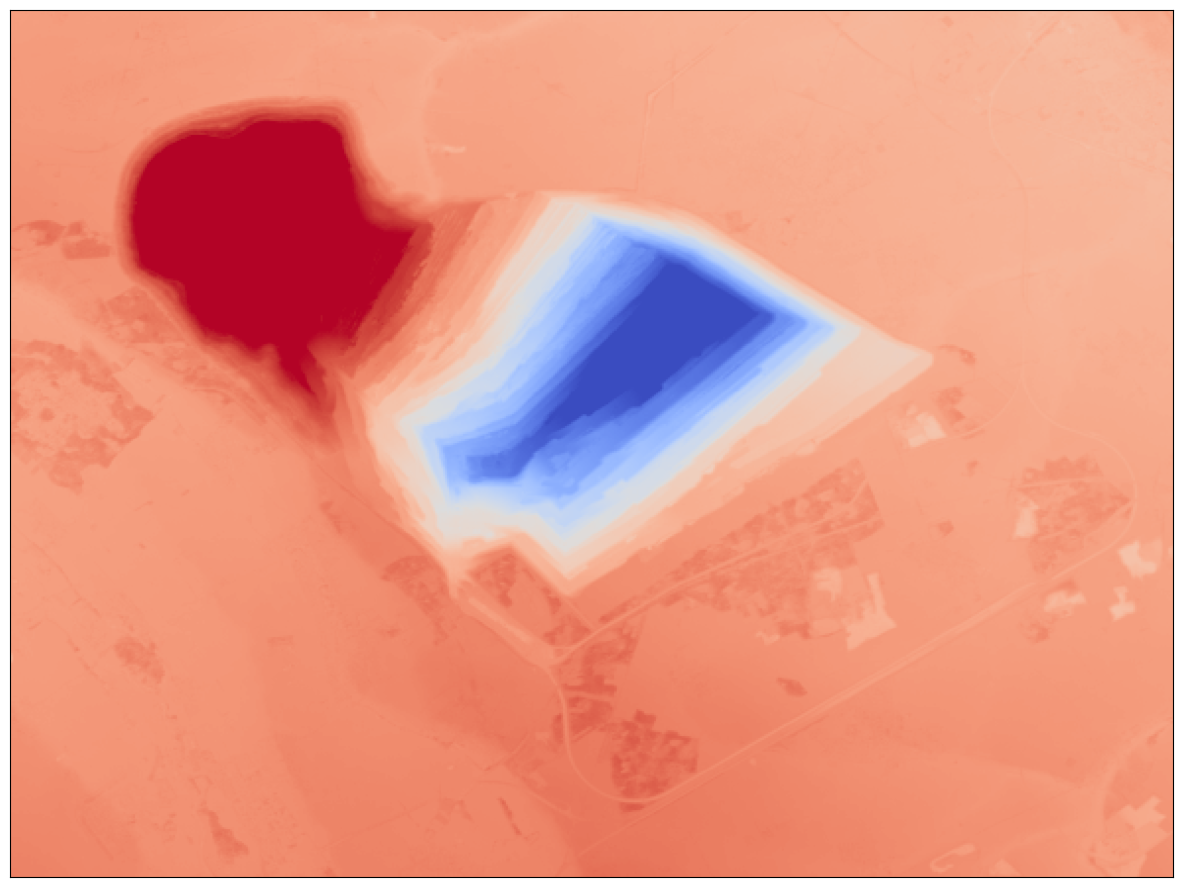

In [9]:
# Plot DEM map
dem_img = dem_data[0]

min_elevation = dem_img.min()
max_elevation = dem_img.max()

# Note: This volume calculation is very rough, and meant as an order of magnitude calculation only
volume = get_volume_from_dem_array(dem_img, resolution=10)

print(f"Minimum elevation in image is: {min_elevation:.2f} m")
print(f"Maximum elevation in image is: {max_elevation:.2f} m")
print(f"Calculated volume of the pit is: {volume:.3f} cubic kilometers")

plot_image(dem_img, factor=1.5, cmap=plt.cm.coolwarm, vmin=min_elevation, vmax=max_elevation)
#plt.savefig("~/project/reports/figures/dida_group_meeting/dem.png", bbox_inches='tight', pad_inches=0)

### DEM_MAPZEN


In [10]:
evalscript_dem_mapzen = """
//VERSION=3
function setup() {
  return {
    input: ["DEM"],
    output:{
      id: "default",
      bands: 1,
      sampleType: SampleType.FLOAT32
    }
  }
}

function evaluatePixel(sample) {
  return [sample.DEM]
}
"""


In [11]:
dem_mapzen_request = SentinelHubRequest(
    data_folder=DATA_DIR / "sentinel_testing" / "hambach" / "dem" / "mapzen",
    evalscript=evalscript_dem_mapzen,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.DEM_MAPZEN,
            time_interval=("2020-06-12", "2020-06-13"),
        )
    ],
    responses=[SentinelHubRequest.output_response("default", MimeType.TIFF)],
    bbox=hambach_bbox,
    size=hambach_size,
    config=config,
)

In [12]:
dem_mapzen_data = dem_mapzen_request.get_data(save_data=True)

Minimum elevation in image is: -227.00 m
Maximum elevation in image is: 287.00 m
Calculated volume of the pit is: 1.113 cubic kilometers


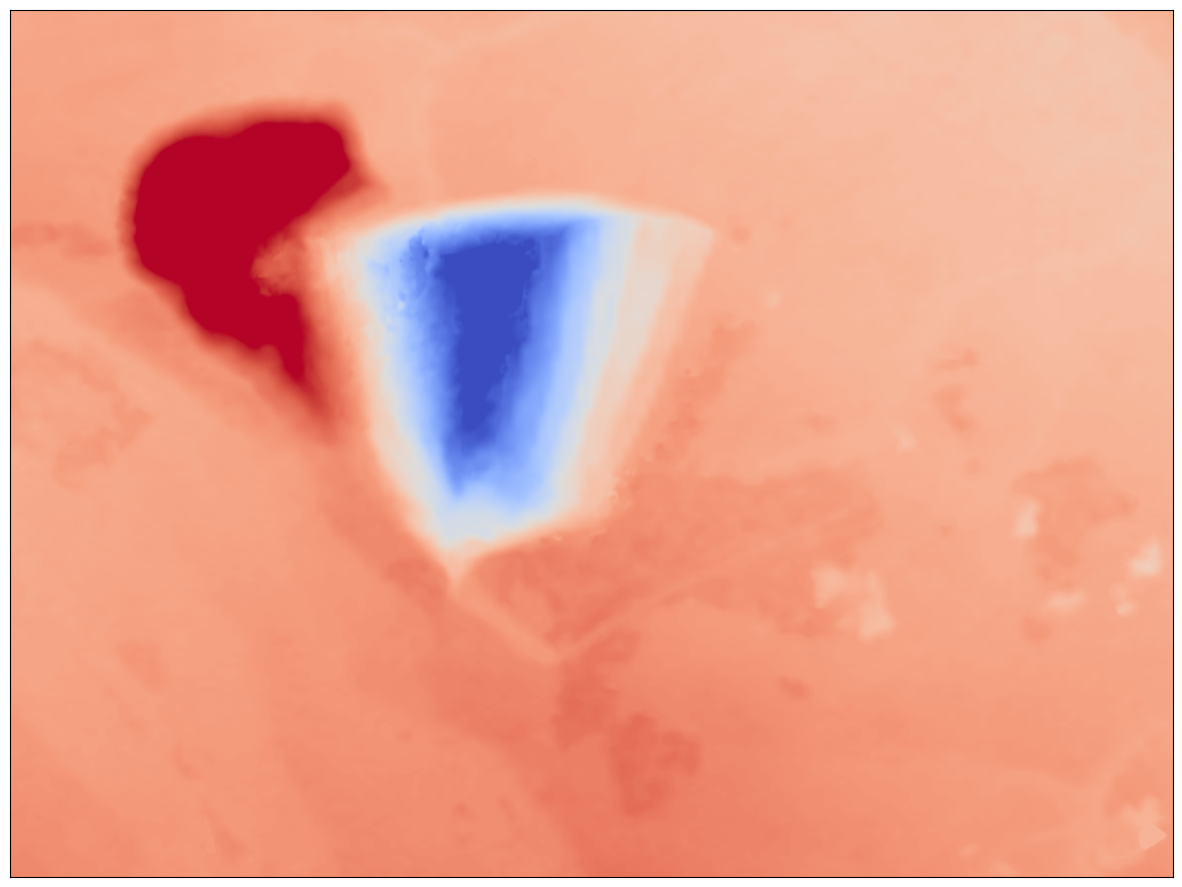

In [13]:
# Plot DEM map
dem_mapzen_img = dem_mapzen_data[0]

min_elevation = dem_mapzen_img.min()
max_elevation = dem_mapzen_img.max()
volume = get_volume_from_dem_array(dem_mapzen_img, resolution=10)

print(f"Minimum elevation in image is: {min_elevation:.2f} m")
print(f"Maximum elevation in image is: {max_elevation:.2f} m")
print(f"Calculated volume of the pit is: {volume:.3f} cubic kilometers")

plot_image(dem_mapzen_img, factor=1.5, cmap=plt.cm.coolwarm, vmin=min_elevation, vmax=max_elevation)

### DEM_COPERNICUS_30


In [14]:
evalscript_dem_cop30 = """
//VERSION=3
function setup() {
  return {
    input: ["DEM"],
    output:{
      id: "default",
      bands: 1,
      sampleType: SampleType.FLOAT32
    }
  }
}

function evaluatePixel(sample) {
  return [sample.DEM]
}
"""


In [15]:
dem_cop30_request = SentinelHubRequest(
    data_folder=DATA_DIR / "sentinel_testing" / "hambach" / "dem" / "cop30",
    evalscript=evalscript_dem_mapzen,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.DEM_COPERNICUS_30,
            time_interval=("2020-06-12", "2020-06-13"),
        )
    ],
    responses=[SentinelHubRequest.output_response("default", MimeType.TIFF)],
    bbox=hambach_bbox,
    size=hambach_size,
    config=config,
)

In [16]:
dem_cop30_data = dem_cop30_request.get_data(save_data=True)

Minimum elevation in image is: -296.76 m
Maximum elevation in image is: 296.11 m
Calculated volume of the pit is: 2.026 cubic kilometers


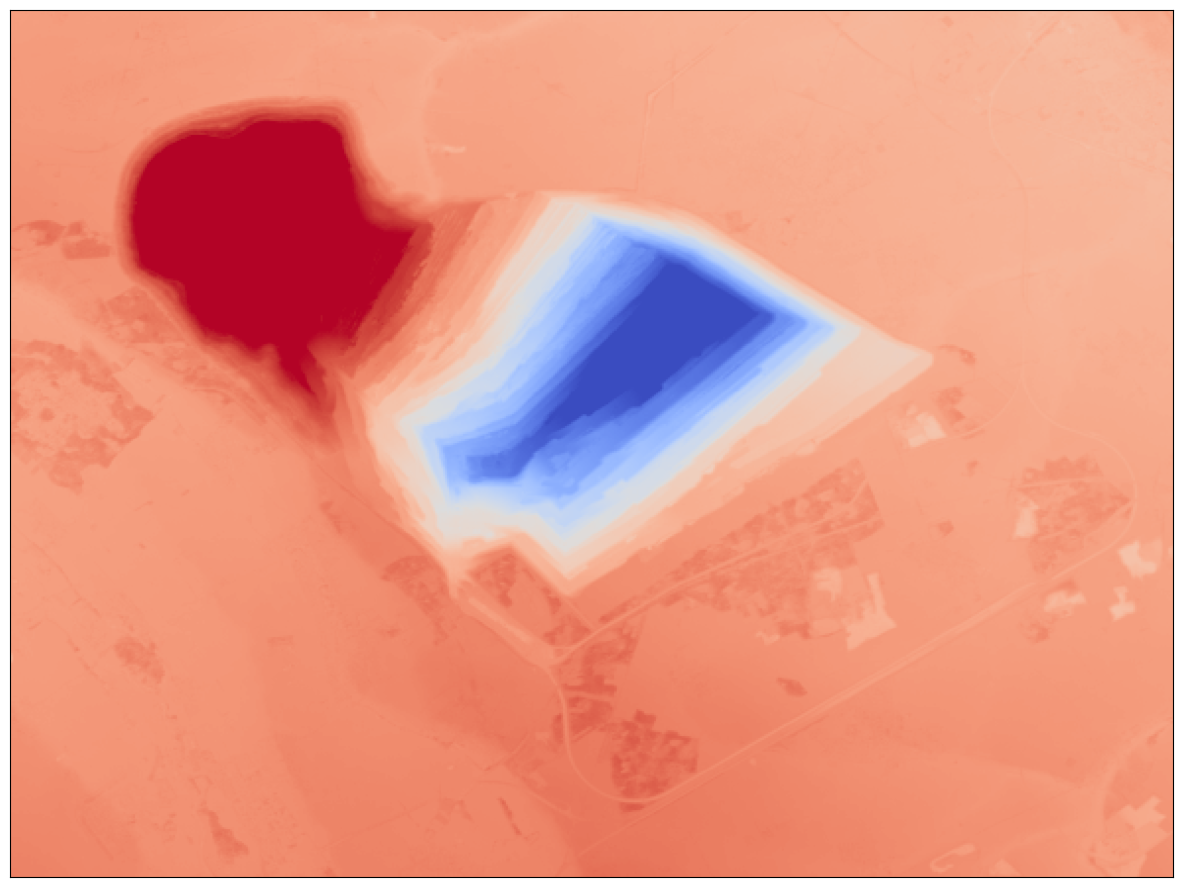

In [17]:
# Plot DEM map
dem_cop30_img = dem_cop30_data[0]

min_elevation = dem_cop30_img.min()
max_elevation = dem_cop30_img.max()
volume = get_volume_from_dem_array(dem_cop30_img, resolution=10)

print(f"Minimum elevation in image is: {min_elevation:.2f} m")
print(f"Maximum elevation in image is: {max_elevation:.2f} m")
print(f"Calculated volume of the pit is: {volume:.3f} cubic kilometers")

plot_image(dem_cop30_img, factor=1.5, cmap=plt.cm.coolwarm, vmin=min_elevation, vmax=max_elevation)

We see that the Copernicus 30 DEM data is the default data returned when DEM is selected (at least in Germany). This also seems to be the most accurate, but Copernicus 30 and MAPZEN are both static and does not depend on the date, so will be unsuitable for tracking volume over time.